In [1]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, cv, DMatrix

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

import numpy as np 
import pandas as pd 

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import os

# Predictive Maintenance of the Air Production Unit on a MetroPT3 locomotive 

  Examining data from an Air Production Unit to classify when a unit is approaching failure. I will examine this data for signs of failure during the hour, day, and week leading up to a failure. I then train classification models to predict whether the various measurements of pressure and temperature are operating under a healthy state, or a state indicative of nearing failure.

From the creators of the Dataset:

The dataset was collected to support the development of predictive maintenance, anomaly detection, and remaining
useful life (RUL) prediction models for compressors using deep learning and machine learning methods.
It consists of multivariate time series data obtained from several analogue and digital sensors installed on the
compressor of a train. The data span between February and August 2020 and includes 15 signals, such as pressures,
motor current, oil temperature, and electrical signals of air intake valves. The monitoring and logging of industrial
equipment events, such as temporal behaviour and fault events, were obtained from records generated by the
sensors. The data were logged at 1Hz by an onboard embedded device. You can find a schematic diagram of the air
production unit of the compressor system in Figure 4 of the accompanying paper [1]. Also, the paper [2] provides a
detailed examination of data collection and specifications of various types of potential failures in an air compressor
system

# Dataset Description

Attribute Information:
The dataset consists of 1516948 data points collected at 1Hz  from February to August 2020 and is described by 15 features from 7 analogue (1-7) and 8 digital (8-15) sensors:
1. TP2 (bar) – the measure of the pressure on the compressor.
2. TP3 (bar) – the measure of the pressure generated at the pneumatic panel.
3. H1 (bar) – the measure of the pressure generated due to pressure drop when the discharge of the cyclonic separator filter occurs.
4. DV pressure (bar) – the measure of the pressure drop generated when the towers discharge air dryers; a zero reading indicates that the compressor is operating under load.
5. Reservoirs (bar) – the measure of the downstream pressure of the reservoirs, which should be close to the pneumatic panel pressure (TP3).
6. Motor Current (A) –  the measure of the current of one phase of the three-phase motor; it presents values close to 0A - when it turns off, 4A - when working offloaded, 7A - when working under load, and 9A - when it starts working.
7. Oil Temperature (ºC) –  the measure of the oil temperature on the compressor.
8. COMP - the electrical signal of the air intake valve on the compressor; it is active when there is no air intake, indicating that the compressor is either turned off or operating in an offloaded state.
9. DV electric – the electrical signal that controls the compressor outlet valve; it is active when the compressor is functioning under load and inactive when the compressor is either off or operating in an offloaded state.
10. TOWERS – the electrical signal that defines the tower responsible for drying the air and the tower responsible for draining the humidity removed from the air; when not active, it indicates that tower one is functioning; when active, it indicates that tower two is in operation.
11. MPG – the electrical signal responsible for starting the compressor under load by activating the intake valve when the pressure in the air production unit (APU) falls below 8.2 bar; it activates the COMP sensor, which assumes the same behaviour as the MPG sensor.
12. LPS – the electrical signal that detects and activates when the pressure drops below 7 bars.
13. Pressure Switch - the electrical signal that detects the discharge in the air-drying towers.
14. Oil Level – the electrical signal that detects the oil level on the compressor; it is active when the oil is below the expected values.
15. Caudal Impulse – the electrical signal that counts the pulse outputs generated by the absolute amount of air flowing from the APU to the reservoirs.

Relevant Papers:
[1]- Davari, N., Veloso, B., Ribeiro, R.P., Pereira, P.M., Gama, J.: Predictive maintenance based on anomaly
detection using deep learning for air production unit in the railway industry. In: 2021 IEEE 8th International
Conference on Data Science and Advanced Analytics (DSAA). pp. 1–10. IEEE (2021) (DOI:
10.1109/DSAA53316.2021.9564181)
 
[2] Veloso, B., Ribeiro, R.P., Pereira, P.M., Gama, J.: The MetroPT dataset for predictive maintenance. Scientific
Data 9, no. 1 (2022): 764. (DOI: 10.1038/s41597-022-01877-3)

[3]-Barros, M., Veloso, B., Pereira, P.M., Ribeiro, R.P., Gama, J.: Failure detection of an air production unit in the
operational context. In: IoT Streams for Data-Driven Predictive Maintenance and IoT, Edge, and Mobile for
Embedded Machine Learning, pp. 61–74. Springer (2020) (DOI: 10.1007/978-3-030-66770-2_5)

Source:
Narjes Davari, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, narjes.davari@inesctec.pt
Bruno Veloso, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, and Faculty of Economics,
University of Porto, Portugal bveloso@fep.up.pt
Rita P. Ribeiro, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, and Faculty of Sciences,
University of Porto, Portugal. rpribeiro@fc.up.pt
Joao Gama, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, and Faculty of Economics,
University of Porto, Portugal. jgama@fep.up.pt

Failure Information:

The dataset is unlabeled, but the failure reports provided by the company are available in the following table. This allows for evaluating the effectiveness of anomaly detection, failure prediction, and RUL estimation algorithms.

  Nr.     Start Time	          End Time	                 Failure	      Severity	         Report
  
#1 	4/18/2020 0:00	   4/18/2020 23:59       Air leak	    High stress	

#2 	5/29/2020 23:30     5/30/2020 6:00	    Air Leak	    High stress	Maintenance on 30Apr at 12:00

#3 	6/5/2020 10:00	   6/7/2020 14:30	        Air Leak	    High stress	Maintenance on 8Jun at 16:00

#4 	7/15/2020 14:30     7/15/2020 19:00      Air Leak	    High stress	Maintenance on 16Jul at 00:00

In [2]:
# Reading in MetroPT3 Air Compressor data

#n = 100  e.g. every 100th line = 1% of the lines
#, skiprows=lambda i: i % n != 0
metro_df_large = pd.read_csv('/kaggle/input/metropt-3-dataset/MetroPT3(AirCompressor).csv', header=0 , index_col ='timestamp')

#metro_df_large = pd.read_csv('/kaggle/input/metropt-3-dataset/MetroPT3(AirCompressor).csv', nrows=800000)
metro_df_large.head()

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
timestamp,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,0,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:10,10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:19,20,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:29,30,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:39,40,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [3]:
metro_df_large.shape

(1516948, 16)

In [4]:
# Renaming columns for legibility, and dropping the duplicate index
metro_df_large = metro_df_large.rename(columns={'DV_eletric':'DV_electric'}).drop(columns=['Unnamed: 0'], axis=1)

# Exploratory Data Analysis

In [5]:
# Summary statistics of the numeric features
metro_df_large.describe()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
count,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06
mean,1.367826e+00,8.984611e+00,7.568155e+00,5.595619e-02,8.985233e+00,6.264418e+01,2.050171e+00,8.369568e-01,1.606106e-01,9.198483e-01,8.326640e-01,3.420025e-03,9.914368e-01,9.041556e-01,9.371066e-01
std,3.250930e+00,6.390951e-01,3.333200e+00,3.824015e-01,6.383070e-01,6.516261e+00,2.302053e+00,3.694052e-01,3.671716e-01,2.715280e-01,3.732757e-01,5.838091e-02,9.214078e-02,2.943779e-01,2.427712e-01
min,-3.200000e-02,7.300000e-01,-3.600000e-02,-3.200000e-02,7.120000e-01,1.540000e+01,2.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-1.400000e-02,8.492000e+00,8.254000e+00,-2.200000e-02,8.494000e+00,5.777500e+01,4.000000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,-1.200000e-02,8.960000e+00,8.784000e+00,-2.000000e-02,8.960000e+00,6.270000e+01,4.500000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,-1.000000e-02,9.492000e+00,9.374000e+00,-1.800000e-02,9.492000e+00,6.725000e+01,3.807500e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,1.067600e+01,1.030200e+01,1.028800e+01,9.844000e+00,1.030000e+01,8.905000e+01,9.295000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
metro_df_large.LPS.value_counts()

0.0    1511760
1.0       5188
Name: LPS, dtype: int64

In [7]:
# Examining null count and data types of features
metro_df_large.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1516948 entries, 2020-02-01 00:00:00 to 2020-09-01 03:59:50
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   TP2              1516948 non-null  float64
 1   TP3              1516948 non-null  float64
 2   H1               1516948 non-null  float64
 3   DV_pressure      1516948 non-null  float64
 4   Reservoirs       1516948 non-null  float64
 5   Oil_temperature  1516948 non-null  float64
 6   Motor_current    1516948 non-null  float64
 7   COMP             1516948 non-null  float64
 8   DV_electric      1516948 non-null  float64
 9   Towers           1516948 non-null  float64
 10  MPG              1516948 non-null  float64
 11  LPS              1516948 non-null  float64
 12  Pressure_switch  1516948 non-null  float64
 13  Oil_level        1516948 non-null  float64
 14  Caudal_impulses  1516948 non-null  float64
dtypes: float64(15)
memory usage: 185.2+ MB


In [8]:
metro_df_large.index.dtype

dtype('O')

In [9]:
# Converting index to datetime datatype
metro_df_large.index = pd.to_datetime(metro_df_large.index) 

# Removing rows that occur during failed periods to create a dataframe of records during normal operation
normal_op_df = pd.DataFrame(metro_df_large.loc[((metro_df_large.index < '04-18-2020 00:00:00') | (metro_df_large.index >'04-18-2020 23:59:00')) & 
                  ((metro_df_large.index < '05-29-2020 23:30:00') | (metro_df_large.index >'05-30-2020 06:00:00')) &
                  ((metro_df_large.index < '06-05-2020 10:00:00') | (metro_df_large.index >'06-07-2020 14:30:00')) &
                  ((metro_df_large.index < '07-15-2020 14:30:00') | (metro_df_large.index >'07-15-2020 19:00:00'))])

In [10]:

normal_op_df.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
timestamp,,,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


# Creating a target feature

The valuable information of the actual machinery failures needs to be transformed into a feature in the dataframe. Here I take steps to create failure_start, failure_end, and failure_duration features. I will use these to test the performance of the classification model.

In [11]:
# Creating a dataframe of failure data from the provided failure table

dt_fail_starts = pd.to_datetime(['2020-04-18 00:00','2020-05-29 23:30','2020-06-05 10:00','2020-07-15 14:30'])
dt_fail_ends = pd.to_datetime(['04-18-2020 23:59', '05-30-2020 6:00', '06-07-2020 14:30', '07-15-2020 19:00'])

fail_ranges_week = [pd.date_range(start=(fail_start - pd.Timedelta(days=7)), end=fail_start) for fail_start in dt_fail_starts]
fail_ranges_day = [pd.date_range(start=(fail_start - pd.Timedelta(days=1)), end=fail_start) for fail_start in dt_fail_starts]
fail_ranges_hour = [pd.date_range(start=(fail_start - pd.Timedelta(hours=1)), end=fail_start) for fail_start in dt_fail_starts]

failure_df = pd.DataFrame(list(zip(fail_ranges_week, fail_ranges_day, fail_ranges_hour, dt_fail_starts, dt_fail_ends)), columns=['pre_fail_week','pre_fail_day','pre_fail_hour','failure_start','failure_end'])


failure_df

,pre_fail_week,pre_fail_day,pre_fail_hour,failure_start,failure_end
0,"DatetimeIndex(['2020-04-11', '2020-04-12', '20...","DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
1,"DatetimeIndex(['2020-05-22 23:30:00', '2020-05...","DatetimeIndex(['2020-05-28 23:30:00', '2020-05...","DatetimeIndex(['2020-05-29 22:30:00'], dtype='...",2020-05-29 23:30:00,2020-05-30 06:00:00
2,"DatetimeIndex(['2020-05-29 10:00:00', '2020-05...","DatetimeIndex(['2020-06-04 10:00:00', '2020-06...","DatetimeIndex(['2020-06-05 09:00:00'], dtype='...",2020-06-05 10:00:00,2020-06-07 14:30:00
3,"DatetimeIndex(['2020-07-08 14:30:00', '2020-07...","DatetimeIndex(['2020-07-14 14:30:00', '2020-07...","DatetimeIndex(['2020-07-15 13:30:00'], dtype='...",2020-07-15 14:30:00,2020-07-15 19:00:00


In [12]:
for col in failure_df.columns:
    failure_df = failure_df.explode(col)

failure_df

,pre_fail_week,pre_fail_day,pre_fail_hour,failure_start,failure_end
0,2020-04-11 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-11 00:00:00,2020-04-18 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-12 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-12 00:00:00,2020-04-18 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-13 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
...,...,...,...,...,...
3,2020-07-13 14:30:00,2020-07-15 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-14 14:30:00,2020-07-14 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-14 14:30:00,2020-07-15 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-15 14:30:00,2020-07-14 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00


In [13]:
hour_pre = failure_df.set_index(failure_df['pre_fail_hour']).sort_index()

In [14]:
tol=pd.Timedelta(hours=1)

hour_pre_fail_df = pd.merge_asof(normal_op_df, hour_pre, left_index=True, right_index=True, tolerance=tol, direction='backward')
hour_pre_fail_df.pre_fail_hour.value_counts()

2020-05-29 22:30:00    363
2020-06-05 09:00:00    363
2020-07-15 13:30:00    363
2020-04-17 23:00:00    298
Name: pre_fail_hour, dtype: int64

In [15]:
hour_pre_fail_df.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_week,pre_fail_day,pre_fail_hour,failure_start,failure_end
timestamp,,,,,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT
2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT
2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT
2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT
2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT


In [16]:
hour_pre_fail_df.loc['2020-04-17 23:00':'2020-04-18 00:00']

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_week,pre_fail_day,pre_fail_hour,failure_start,failure_end
timestamp,,,,,,,,,,,,,,,,,,,,
2020-04-17 23:00:06,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2020-04-18,2020-04-18,2020-04-17 23:00:00,2020-04-18,2020-04-18 23:59:00
2020-04-17 23:00:18,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2020-04-18,2020-04-18,2020-04-17 23:00:00,2020-04-18,2020-04-18 23:59:00
2020-04-17 23:00:30,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-04-18,2020-04-18,2020-04-17 23:00:00,2020-04-18,2020-04-18 23:59:00
2020-04-17 23:00:43,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2020-04-18,2020-04-18,2020-04-17 23:00:00,2020-04-18,2020-04-18 23:59:00
2020-04-17 23:00:55,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2020-04-18,2020-04-18,2020-04-17 23:00:00,2020-04-18,2020-04-18 23:59:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-17 23:59:00,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2020-04-18,2020-04-18,2020-04-17 23:00:00,2020-04-18,2020-04-18 23:59:00
2020-04-17 23:59:12,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2020-04-18,2020-04-18,2020-04-17 23:00:00,2020-04-18,2020-04-18 23:59:00
2020-04-17 23:59:24,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-04-18,2020-04-18,2020-04-17 23:00:00,2020-04-18,2020-04-18 23:59:00


In [17]:
hour_pre_fail_df.shape

(1486994, 20)

In [18]:
hour_pre_fail_df['pre_fail_hour_binary'] = np.where(np.isnan(hour_pre_fail_df['pre_fail_hour'].values), 0, 1)

hour_pre_fail_df['pre_fail_hour_binary'].value_counts()

0    1485607
1       1387
Name: pre_fail_hour_binary, dtype: int64

In [19]:
day_pre = failure_df.set_index(failure_df['pre_fail_day']).sort_index()

In [20]:
tol=pd.Timedelta(1, "D")

day_pre_fail_df = pd.merge_asof(normal_op_df, day_pre, left_index=True, right_index=True, tolerance=tol)

day_pre_fail_df.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_week,pre_fail_day,pre_fail_hour,failure_start,failure_end
timestamp,,,,,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT
2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT
2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT
2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT
2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT


In [21]:
day_pre_fail_df.pre_fail_day.value_counts()

2020-06-04 10:00:00    8716
2020-05-28 23:30:00    7466
2020-07-15 14:30:00    7038
2020-04-17 00:00:00    6301
2020-05-29 23:30:00    6256
2020-07-14 14:30:00    6185
2020-04-18 00:00:00       6
Name: pre_fail_day, dtype: int64

In [22]:
day_pre_fail_df['pre_fail_day_binary'] = np.where(np.isnan(day_pre_fail_df['pre_fail_day'].values), 0, 1)

day_pre_fail_df['pre_fail_day_binary'].value_counts()

0    1445026
1      41968
Name: pre_fail_day_binary, dtype: int64

In [23]:
week_pre = failure_df.set_index(failure_df['pre_fail_week']).sort_index()

In [24]:
tol=pd.Timedelta(1, "W")

week_pre_fail_df = pd.merge_asof(normal_op_df, week_pre, left_index=True, right_index=True, tolerance=tol)

week_pre_fail_df.pre_fail_week.value_counts()

2020-07-15 14:30:00    56776
2020-04-18 00:00:00    46888
2020-06-05 10:00:00    30622
2020-06-04 10:00:00     8716
2020-06-01 10:00:00     8680
2020-05-31 10:00:00     8462
2020-04-15 00:00:00     8433
2020-05-27 23:30:00     8404
2020-07-08 14:30:00     8373
2020-05-22 23:30:00     8320
2020-04-16 00:00:00     8027
2020-06-03 10:00:00     7976
2020-05-30 10:00:00     7356
2020-07-09 14:30:00     7282
2020-04-11 00:00:00     7229
2020-04-12 00:00:00     7125
2020-05-26 23:30:00     7095
2020-05-24 23:30:00     6840
2020-04-14 00:00:00     6329
2020-04-17 00:00:00     6301
2020-07-14 14:30:00     6185
2020-07-12 14:30:00     6134
2020-07-13 14:30:00     5939
2020-07-10 14:30:00     5536
2020-05-25 23:30:00     5520
2020-07-11 14:30:00     5457
2020-06-02 10:00:00     5167
2020-05-29 10:00:00     4903
2020-04-13 00:00:00     3501
2020-05-28 23:30:00     2563
2020-05-29 23:30:00     1353
2020-05-23 23:30:00      348
Name: pre_fail_week, dtype: int64

In [25]:
week_pre_fail_df['pre_fail_week_binary'] = np.where(np.isnan(week_pre_fail_df['pre_fail_week'].values), 0, 1)

week_pre_fail_df['pre_fail_week_binary'].value_counts()

0    1169154
1     317840
Name: pre_fail_week_binary, dtype: int64

In [26]:
merged_df = pd.DataFrame({'week':week_pre_fail_df['pre_fail_week_binary'],'day':day_pre_fail_df['pre_fail_day_binary'],'hour':hour_pre_fail_df['pre_fail_hour_binary']})

In [27]:
print(merged_df.value_counts())
merged_df.head()

week  day  hour
0     0    0       1169154
1     0    0        275872
      1    0         40581
           1          1387
dtype: int64


,week,day,hour
timestamp,,,
2020-02-01 00:00:00,0,0,0
2020-02-01 00:00:10,0,0,0
2020-02-01 00:00:19,0,0,0
2020-02-01 00:00:29,0,0,0
2020-02-01 00:00:39,0,0,0


In [28]:
print(merged_df.shape[0], normal_op_df.shape[0])

1486994 1486994


In [29]:
model_df = normal_op_df.merge(merged_df, left_index=True, right_index=True)

In [30]:
model_df.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,week,day,hour
timestamp,,,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0
2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0
2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0
2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0
2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0


# Initial Indicators of Failure State

Examining the relationship between oil temperature, oil level and the dv_electric state, separated into normal operation and the 24 hours pre-failure. The oil level variable is True when the oil level is below the expected level. The DV_electric variable is 1.0/True when the compressor is operating under load and 0/False when compressor is off or operating in an offloaded state.

**As shown, when the compressor is within the 24 hours leading up to a failure**:

    1. The oil level variable is almost exclusively True, indicating a lower than expected oil level.

    2. Oil temperature during offloaded state with low oil level is similar to normal operation temperatures, apart from the large aggregation at the relatively low ~50 degrees Celsius.

    3. Oil temperature during a loaded state with lower than expected oil levels reveals a heavily aggregated cluster at ~72-78 degrees Celsius. Under normal operation but with low oil levels, the oil temperature reaches these temperatures, but also includes many values near ~70 degrees C and near 65 degrees C. This could indicate that during the 24 hours pre failure, oil temperatures rise quickly to a high but acceptable maximum temperature while operating under load and having a lower than expected oil level.
    
These conclusions could point to drastic changes in oil temperature leading to failures. Many materials can be developed to withstand temperature extremes, but drastic changes in temperature can lead to differing rates of expansion/contraction within the system, or within the same component.

<Figure size 1200x800 with 0 Axes>

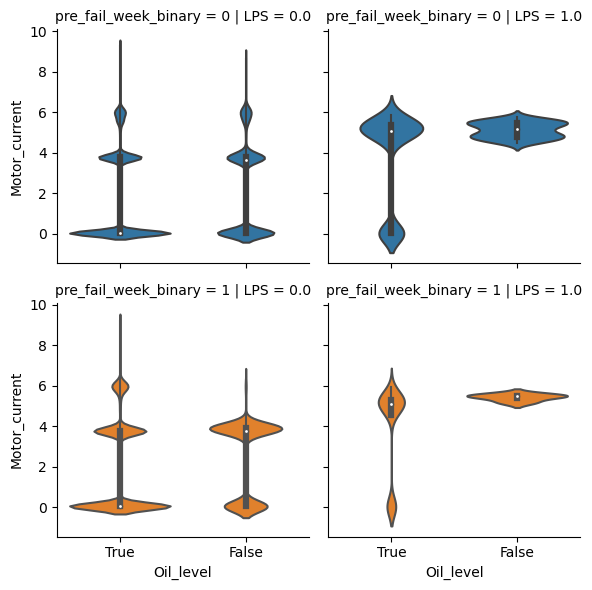

In [31]:
plt.figure(figsize=(12, 8))
grid = sns.FacetGrid(week_pre_fail_df, row='pre_fail_week_binary', col='LPS', hue='pre_fail_week_binary')
grid.map(sns.violinplot, 'Oil_level', 'Motor_current', order=[True, False])

<Figure size 1200x800 with 0 Axes>

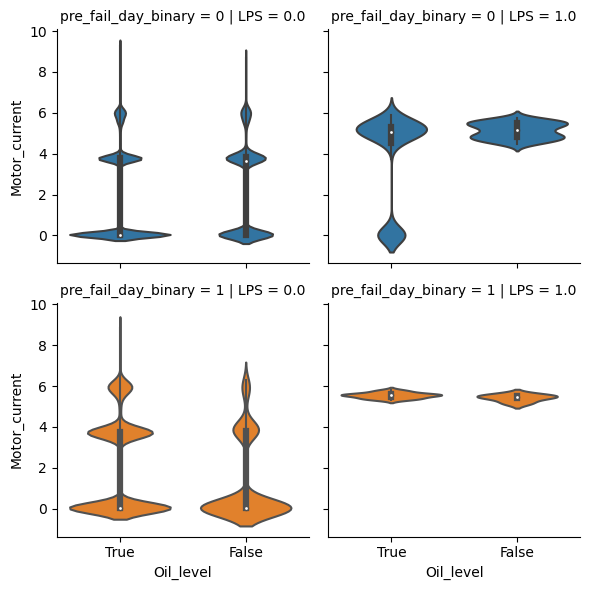

In [32]:
plt.figure(figsize=(12, 8))
grid = sns.FacetGrid(day_pre_fail_df, row='pre_fail_day_binary', col='LPS', hue='pre_fail_day_binary')
grid.map(sns.violinplot, 'Oil_level', 'Motor_current', order=[True, False])

<Figure size 1200x800 with 0 Axes>

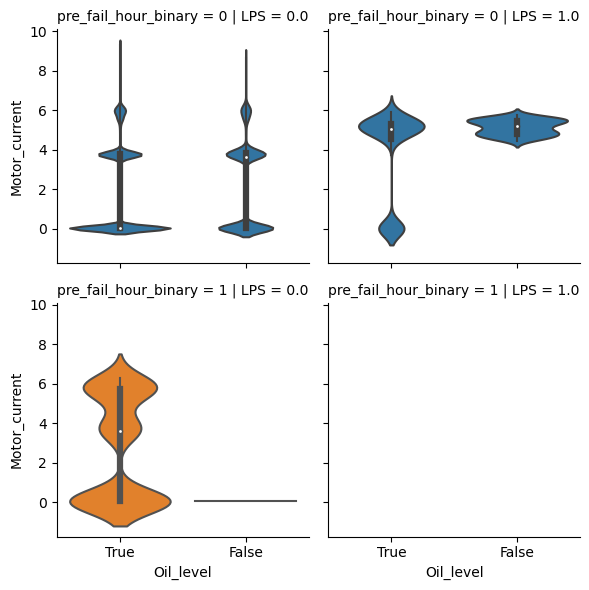

In [33]:
plt.figure(figsize=(12, 8))
grid = sns.FacetGrid(hour_pre_fail_df, row='pre_fail_hour_binary', col='LPS', hue='pre_fail_hour_binary')
grid.map(sns.violinplot, 'Oil_level', 'Motor_current', order=[True, False])

The median oil temperature during the hour leading up to a failure is slightly higher, and includes no low temperature outliers, which which would indicate a compressor operating in a non-loaded/ less-stressed state.The oil temperature while under normal operation indicates a lower median and has many low temperature outliers.

Next, I create a comparison of the DV_pressure between normal operation data and one hour pre failure data. When this value is zero, it indicates the compressor is operating under load. As shown in the plot, the data from an hour before failure is operating under load much more frequently. As this is expected and intuitive, further plots will examine the details of the compressor Operating Under Load.

# Initial Model Training + Evaluation

Now I have a dataframe of records under normal operation, merged with the column indicating True/False if the data occured during the day leading up to a known failure.

For use in the model, I create a dataframe of the continuous numeric variables and the target pre_fail_hour variable. While other variables may prove useful later, they are essentially On/Off features, and that could distort the accuracy of the model without more careful consideration.

In [34]:
model_df = model_df[['TP2','TP3','H1','DV_pressure','Reservoirs','Oil_temperature','Oil_level','Motor_current','week','day','hour']]

With this dataframe, a correlation matrix is calculated and presented as a heatmap. This is used to eliminate one or both features if they are highly correlated.

Seen in the plot, the TP3 and Reservoirs features are very highly correlated, and there is a decision to be made on which to drop. These two features measure the pressure generated at the pneumatic panel (TP3), and the pressure measured downstream at the reservoirs(Reservoirs). Under normal operation, these will be nearly identical, which shows in the correlation value of 1. I will drop the TP3 feature, as the measurement downstream is more likely to indicate a change in function.

Also highly correlated are the TP2 and H1 values. These are the pressure on the compressor (TP2), and the measure of the pressure generated due to pressure drop when the discharge of the cyclonic separator filter occurs (H1). For the initial model I will drop the H1 column, as the actual measured pressure on the compressor should not be dropped.

<Axes: >

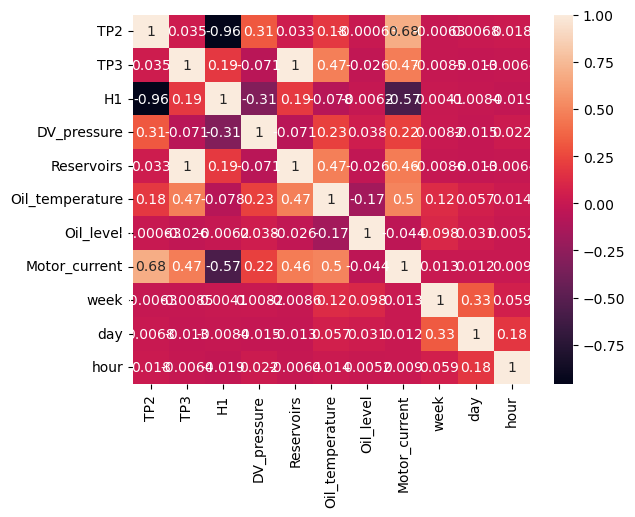

In [35]:
# This calculates the correlation between each feature and all of the others
corr = model_df.corr()
# Creating and plotting the heatmap with seaborn
sns.heatmap(corr, annot=True)

In [36]:
# Dropping the highly correlated columns
model_df = model_df.drop(columns=['H1', 'TP3'])

In [37]:
model_df.head()

,TP2,DV_pressure,Reservoirs,Oil_temperature,Oil_level,Motor_current,week,day,hour
timestamp,,,,,,,,,
2020-02-01 00:00:00,-0.012,-0.024,9.358,53.600,1.0,0.0400,0,0,0
2020-02-01 00:00:10,-0.014,-0.022,9.348,53.675,1.0,0.0400,0,0,0
2020-02-01 00:00:19,-0.012,-0.022,9.338,53.600,1.0,0.0425,0,0,0
2020-02-01 00:00:29,-0.012,-0.022,9.328,53.425,1.0,0.0400,0,0,0
2020-02-01 00:00:39,-0.012,-0.022,9.318,53.475,1.0,0.0400,0,0,0


In [38]:
# Sanity check of target feature values
model_df.day.value_counts()

0    1445026
1      41968
Name: day, dtype: int64

In [39]:
# Resetting the index to sequential integers and dropping the datetime column entirely
model_df = model_df.reset_index(drop=True)
model_df.head()

,TP2,DV_pressure,Reservoirs,Oil_temperature,Oil_level,Motor_current,week,day,hour
0,-0.012,-0.024,9.358,53.600,1.0,0.0400,0,0,0
1,-0.014,-0.022,9.348,53.675,1.0,0.0400,0,0,0
2,-0.012,-0.022,9.338,53.600,1.0,0.0425,0,0,0
3,-0.012,-0.022,9.328,53.425,1.0,0.0400,0,0,0
4,-0.012,-0.022,9.318,53.475,1.0,0.0400,0,0,0


In [40]:
# Creating the X data from the pertinent columns of the model ready dataframe
X = model_df[['TP2', 'Reservoirs', 'DV_pressure','Oil_temperature', 'Motor_current']]

# Declaring the target column of pre_fail_hour as the y or target data
y = model_df['hour']

# Splitting the data into training and testing, stratifying by the y variable of pre_fail_hour as it has greatly imbalanced class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Using scikit learn's StandardScaler, fitting it on only the X_train data, then transforming both X_train and X_test data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[-0.39727168,  0.4177855 , -0.15018392, -0.69630028, -0.85387217],
       [-0.39599527,  0.33880054, -0.14296507,  0.84749999, -0.85277084],
       [-0.4004627 ,  1.76368928, -0.12852737,  1.85156545,  0.73865298],
       ...,
       [-0.39854809, -0.58690323, -0.15740277, -1.80355034, -0.85497351],
       [ 2.96479266,  1.83003665, -0.14296507,  1.74044358,  1.85870698],
       [-0.39599527, -0.13826864, -0.12852737, -0.56930386, -0.85717617]])

In [41]:
# Checking the counts of True/False values in the training and test target datasets
print(y_train.value_counts())
print(y_test.value_counts())

0    1039924
1        971
Name: hour, dtype: int64
0    445683
1       416
Name: hour, dtype: int64


Using the sci-kit learn Logistic Regression model, adjusting for the imbalanced classes in the target column, achieves a decent initial F1 score of ~0.70. There is room for improvement with further hyperparameter tuning, feature generation, and comparison with other models. 

The feature importances plot below indicates how strongly a feature affects the determination of a data point being near a failure, or operating normally.
The two strongest features by some degree are oil temperature, and the downstream pressure of the reservoirs.

Accuracy: 0.7024270397378161
Precision: 0.0016419742857788457
Recall: 0.5240384615384616
F1 Score: 0.8243398409964522


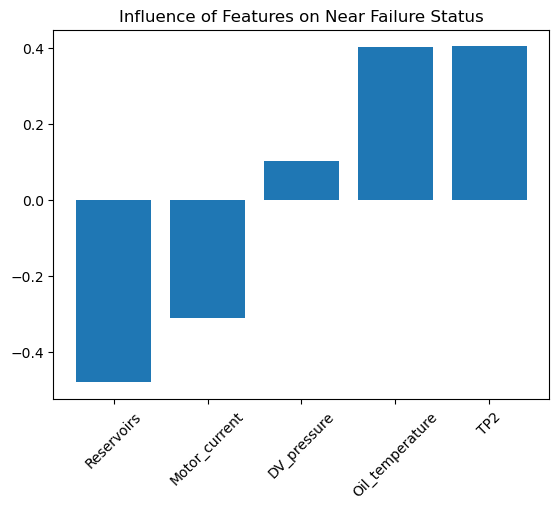

In [42]:
# Instantiating a scikit-learn Logistic Regression model with class weights set to counteract the imbalanced target classes
logreg_1 = LogisticRegression(random_state=17, class_weight={True:1000, False:1})

# Fitting the model with the training data
logreg_1.fit(X_train, y_train)

# Predicting target values from the test data
y_pred = logreg_1.predict(X_test)

# Accessing the feature_importances of the model after fitting
feature_importances = pd.DataFrame(data={"Feature": X.columns, "Importance": logreg_1.coef_[0]}).sort_values(by='Importance')

# Calculating and printing model evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

# Plotting the feature importances as a bar chart
plt.bar(feature_importances["Feature"], feature_importances["Importance"])
plt.xticks(rotation=45)
plt.title("Influence of Features on Near Failure Status")
plt.show()

In [43]:
# Instantiating an XGBoost Classifier model for binary classification via logistic regression (this model needs work)
xgb_model = XGBClassifier(objective='binary:logistic', n_estimators=10, seed=17)

# Fitting the model to the training data
xgb_model.fit(X_train, y_train)

# Making predictions of near failure True/False on the test data
y_pred = xgb_model.predict(X_test)

# Using scikit-learn's classification report to calculate and display model evaluation metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    445683
           1       0.91      0.27      0.41       416

    accuracy                           1.00    446099
   macro avg       0.95      0.63      0.71    446099
weighted avg       1.00      1.00      1.00    446099



In [44]:
# Further parameter, hyperparameter tuning, and stratification of imbalanced class data methods to be experimented
"""params={"objective":"binary:logistic","max_depth":4}

dtrain = DMatrix(X_train, y_train)

cv_results = cv(dtrain=dtrain, params=params, nfold=4, num_boost_round=10, metrics="error", as_pandas=True)

print("Accuracy: %f" %((1-cv_results["test-error-mean"]).iloc[-1]))"""

'params={"objective":"binary:logistic","max_depth":4}\n\ndtrain = DMatrix(X_train, y_train)\n\ncv_results = cv(dtrain=dtrain, params=params, nfold=4, num_boost_round=10, metrics="error", as_pandas=True)\n\nprint("Accuracy: %f" %((1-cv_results["test-error-mean"]).iloc[-1]))'

# Feature Generation

The BAR pressure value in the reservoirs ('Reservoirs') should be close to that measured at the pneumatic panel (TP3).
Next I create a dif_panel_reservoir feature by subtracting the value of 'Reservoirs' from the value of 'TP3' for each record.

Feature extraction:
* rolling averages of features
* frequency of n percentile measurements (high stress / temp / motor current)
* 